https://github.com/mwaskom/seaborn/issues/3462

In [ ]:
pip install

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
pip install torchmetrics

In [ ]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 808.5/808.5 kB 14.5 MB/s eta 0:00:00


In [ ]:
import warnings

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import lightning.pytorch as pl
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics.functional import accuracy
from torchmetrics import F1Score

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

In [ ]:
bank_customer_churn_data = pd.read_csv("./Churn_Modelling.csv")

bank_customer_churn_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [ ]:
bank_customer_churn_data .columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [ ]:
bank_customer_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


In [ ]:
bank_customer_churn_data.dropna(inplace = True)

bank_customer_churn_data = bank_customer_churn_data.drop_duplicates()

bank_customer_churn_data.shape

(9996, 14)

Dataset balance is checked

In [ ]:
bank_customer_churn_data["Exited"].value_counts()

,count
Exited,
0,7959
1,2037


<Axes: xlabel='Exited', ylabel='count'>

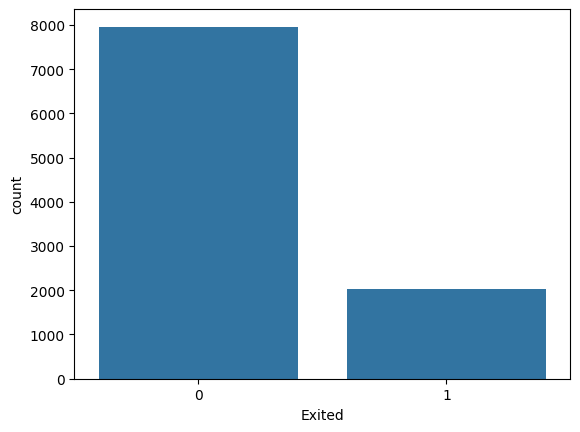

In [ ]:
sns.countplot(data = bank_customer_churn_data  , x = "Exited")

Here for Classification Model with Pytorch lightning, We are directly setting up the codes for Datamodule

In [ ]:
class BankCustomerChurnDataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 8):
        super().__init__()

        self.batch_size = batch_size

    def prepare_data(self):
        self.bank_customer_churn_data = pd.read_csv("./Churn_Modelling.csv")

        self.bank_customer_churn_data = self.bank_customer_churn_data.dropna()
        self. bank_customer_churn_data = self.bank_customer_churn_data.drop_duplicates()

    def setup(self, stage = None):
        X = self.bank_customer_churn_data.drop(
            columns = ["Exited", "RowNumber", "CustomerId", "Surname"]
        )
        y = self.bank_customer_churn_data["Exited"]

        if stage == "fit" or stage is None:
            X_train, X_val, y_train, y_val = \
                train_test_split(X, y, test_size = 0.2, random_state = 123)

            ## One hot encoding categorical features
            categorical_features = ['Geography', 'Gender']

            categorical_transformer = OneHotEncoder(
                handle_unknown = 'ignore', drop = 'first', sparse_output = False
            )

            preprocessor = ColumnTransformer(
                transformers = [('cat_tr', categorical_transformer, categorical_features)],
                remainder='passthrough'
            )

            X_train = preprocessor.fit_transform(X_train)
            X_val = preprocessor.transform(X_val)

            y_train, y_val = np.array(y_train), np.array(y_val)

            ## Scaling Inputs
            scaler = StandardScaler()

            inputs_train_array = scaler.fit_transform(X_train)
            inputs_val_array = scaler.transform(X_val)

            ## Input arrays and labels are converted into tensors
            self.train_inputs = torch.from_numpy(inputs_train_array).float()
            self.train_targets = torch.from_numpy(y_train.reshape(-1, 1)).float()
            self.val_inputs = torch.from_numpy(inputs_val_array).float()
            self.val_targets = torch.from_numpy(y_val.reshape(-1,1 )).float()

    def train_dataloader(self):
        train_dataset = TensorDataset(self.train_inputs, self.train_targets)
        train_loader = DataLoader(
            dataset = train_dataset, batch_size = self.batch_size, num_workers = 4
        )

        return train_loader

    def val_dataloader(self):
        validation_dataset = TensorDataset(self.val_inputs, self.val_targets)
        validation_loader = DataLoader(
            dataset = validation_dataset, batch_size = self.batch_size, num_workers = 4
        )

        return validation_loader

In [ ]:
bank_customer_churn_dm = BankCustomerChurnDataModule()

bank_customer_churn_dm.prepare_data()
bank_customer_churn_dm.setup()

In [ ]:
train_dl = bank_customer_churn_dm.train_dataloader()

sample_train_data_batch = next(iter(train_dl))

sample_train_data_batch

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[tensor([[-5.7812e-01, -5.7465e-01,  9.0655e-01,  7.3023e-01, -3.7092e-01,
           1.7379e+00, -1.2208e+00,  8.1028e-01,  6.4321e-01, -1.0287e+00,
          -4.9144e-01],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01, -1.6488e+00, -9.4915e-01,
          -3.4805e-01, -1.2208e+00,  8.1028e-01,  6.4321e-01, -1.0287e+00,
          -1.1807e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  8.3322e-01, -9.4915e-01,
          -3.9131e-04,  1.6494e+00, -9.1791e-01, -1.5547e+00, -1.0287e+00,
           2.1372e-01],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  8.3322e-01, -7.5640e-01,
          -1.3910e+00,  8.9763e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           1.4954e+00],
         [-5.7812e-01, -5.7465e-01,  9.0655e-01,  2.0588e+00,  1.6529e+00,
           6.9493e-01,  8.7853e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           3.3874e-01],
         [ 1.7297e+00, -5.7465e-01, -1.1031e+00, -3.3054e-01, -9.4915e-01,
           1.7379e+00,  3.8292e-01,  8.1028e-01,  6.432

In [ ]:
num_features = sample_train_data_batch[0].shape[1]

num_features

11

In [ ]:
val_dl = bank_customer_churn_dm.val_dataloader()

next(iter(val_dl))

[tensor([[-5.7812e-01, -5.7465e-01,  9.0655e-01,  1.0289e+00, -8.1809e-02,
          -3.9131e-04,  1.2017e+00, -9.1791e-01,  6.4321e-01,  9.7212e-01,
          -9.2831e-01],
         [ 1.7297e+00, -5.7465e-01, -1.1031e+00,  5.4485e-01, -9.4915e-01,
          -6.9571e-01,  7.3093e-01, -9.1791e-01, -1.5547e+00,  9.7212e-01,
          -2.9551e-01],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00,  2.0588e+00,  6.8916e-01,
          -6.9571e-01, -1.2208e+00,  8.1028e-01,  6.4321e-01,  9.7212e-01,
           1.5392e+00],
         [ 1.7297e+00, -5.7465e-01,  9.0655e-01,  9.3199e-03, -1.2383e+00,
          -3.9131e-04,  1.1298e+00, -9.1791e-01, -1.5547e+00, -1.0287e+00,
           7.3284e-01],
         [ 1.7297e+00, -5.7465e-01,  9.0655e-01,  1.2555e+00, -4.6729e-01,
           6.9493e-01,  5.6278e-01, -9.1791e-01,  6.4321e-01,  9.7212e-01,
           3.7185e-01],
         [-5.7812e-01, -5.7465e-01, -1.1031e+00, -2.6875e-01,  3.0984e+00,
          -3.4805e-01,  1.5010e+00,  2.5385e+00,  6.432

In the Lightning Module , our neural network model is the simplest one which is equivalent to Logistic Regression model. We configure optimizers same as that of Regression demo.  For the training and validation steps,loss function configured is BCEWithLogitsLoss
link-https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html.
We are logging train loss for training step and logging validation loss, accuracy and f1 score


In [ ]:
class LitBinaryClassificationModule(pl.LightningModule):

    def __init__(self, num_features, learning_rate = 0.001):
        super().__init__()

        self.layer1 = nn.Linear(num_features, 16)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(16, 8)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(8, 4)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(4, 1)
        self.save_hyperparameters()

    def forward(self, x):

        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.output(x)

        return x

    def training_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)

        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, y)

        self.log("train_loss", loss, on_step = False, on_epoch = True, prog_bar = True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch

        logits = self(x)

        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(logits, y)

        preds = torch.round(torch.sigmoid(logits))

        acc = accuracy(preds, y, task = "binary")

        f1_score = F1Score(task = "binary")
        f1 = f1_score(preds, y)

        self.log(f"val_loss", loss, on_epoch = True, prog_bar = True)
        self.log(f"val_acc", acc, on_epoch = True, prog_bar = True)
        self.log(f"val_f1", f1, on_epoch = True, prog_bar = True)

    def predict_step(self, batch, batch_idx, dataloader_idx = 0):
        x, y = batch

        return self(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr = self.hparams.learning_rate)

In [ ]:
lit_clf_nn_model = LitBinaryClassificationModule(num_features = num_features)

print(lit_clf_nn_model)

LitBinaryClassificationModule(
  (layer1): Linear(in_features=11, out_features=16, bias=True)
  (act1): ReLU()
  (layer2): Linear(in_features=16, out_features=8, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=8, out_features=4, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
from pytorch_lightning.loggers import CSVLogger

bank_customer_churn_dm = BankCustomerChurnDataModule()

logger = CSVLogger("logs", name = "pytorch_lightning_classification")

trainer = pl.Trainer(max_epochs = 20, logger = logger)

trainer.fit(lit_clf_nn_model , datamodule = bank_customer_churn_dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 192    | train
1 | act1   | ReLU   | 0      | train
2 | layer2 | Linear | 136    | train
3 | act2   | ReLU   | 0      | train
4 | layer3 | Linear | 36     | train
5 | act3   | ReLU   | 0      | train
6 | output | Linear | 5      | train
------------------------------------------
369       Trainable params
0         Non-trainable params
369       Total params
0.001     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 192    | train
1 | act1   | ReLU   | 0      | train
2 | layer2 | Linear | 136    | train
3 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

metrics

,epoch,step,train_loss,val_acc,val_f1,val_loss
0,0,999,NaN,0.8565,0.424574,0.345796
1,0,999,0.331119,NaN,NaN,NaN
2,1,1999,NaN,0.8560,0.419774,0.345225
3,1,1999,0.330524,NaN,NaN,NaN
4,2,2999,NaN,0.8570,0.420574,0.345234
5,2,2999,0.329653,NaN,NaN,NaN
6,3,3999,NaN,0.8570,0.425527,0.345264
7,3,3999,0.328991,NaN,NaN,NaN
8,4,4999,NaN,0.8575,0.424460,0.345353
9,4,4999,0.328339,NaN,NaN,NaN


,train_loss,val_acc,val_f1,val_loss
epoch,,,,
0,NaN,0.8565,0.424574,0.345796
0,0.331119,NaN,NaN,NaN
1,NaN,0.8560,0.419774,0.345225
1,0.330524,NaN,NaN,NaN
2,NaN,0.8570,0.420574,0.345234


<Axes: xlabel='epoch'>

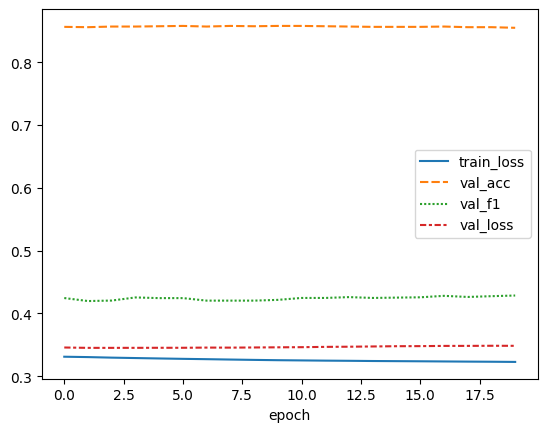

In [ ]:
del metrics["step"]

# Set the epoch column as the index, for easier plotting
metrics.set_index("epoch", inplace = True)

# Display the first few rows of the metrics table, excluding any columns with all NaN values
display(metrics.dropna(axis = 1, how = "all").head())

# Create a line plot of the training metrics using Seaborn
sns.lineplot(data = metrics)

Raw logits are obtained

In [ ]:
y_pred_stacked = torch.cat(
    trainer.predict(model = lit_clf_nn_model , dataloaders = bank_customer_churn_dm.val_dataloader())
)

y_pred_stacked[:10]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: |          | 0/? [00:00<?, ?it/s]

tensor([[-2.8802],
        [-1.3914],
        [-3.2517],
        [-1.0089],
        [-2.1109],
        [ 2.0495],
        [-4.2743],
        [-2.7642],
        [-4.8008],
        [-4.1883]])

Converting raw logits into hard predictions

In [ ]:
y_pred = torch.round(torch.sigmoid(y_pred_stacked))

y_pred[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])

True labels are obtained

In [ ]:
labels = []

for data, label in bank_customer_churn_dm.val_dataloader():
    labels.extend(label)

In [ ]:
y_true = torch.stack(labels)

y_true[:10]

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
y_true.shape

torch.Size([2000, 1])

In [ ]:
from torchmetrics.classification import BinaryAccuracy
from torchmetrics import Recall, Precision, F1Score

acc = BinaryAccuracy()
prec = Precision(task = 'binary')
recall = Recall(task = 'binary')
f1 = F1Score(task = 'binary')

print("Accuracy_score :", round(acc(y_pred, y_true).item(),3))
print("Precision_score :", round(prec(y_pred,y_true).item(),3))
print("Recall_score :" , round(recall(y_pred,y_true).item(),3))
print("F1_score :" , round(f1(y_pred,y_true).item(),3))

Accuracy_score : 0.855
Precision_score : 0.74
Recall_score : 0.489
F1_score : 0.589
